# Entity Resolution project @ Wavestone
## Blocking with sentence embeddings

> **Tristan PERROT**


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:2


In [3]:
while 'model' not in os.listdir():
    os.chdir('..')

In [4]:
%pip install deepmatcher

Note: you may need to restart the kernel to use updated packages.


In [5]:
from model.utils import load_data
import deepmatcher as dm

/home/infres/tperrot-21/venv/lib/python3.12/site-packages/torchtext/__init__.py:7: SyntaxWarning: invalid escape sequence '\ '
  "\n/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ \n"


OSError: /home/infres/tperrot-21/venv/lib/python3.12/site-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs

In [146]:
MODEL_NAME = ''
DATA_NAME = 'amazon-google'
COMPUTER = 'gpu4.enst.fr:' + str(device)[-1:]
DATA_DIR = os.path.join('data', DATA_NAME)

In [147]:
table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(DATA_DIR, remove_col_names=True)
table_a_serialized[:5]

Table A columns:
    column_name data_example
1   description          NaN
2  manufacturer   broderbund
3         price          0.0 

Table B columns:
    column_name              data_example
1   description  learning quickbooks 2007
2  manufacturer                    intuit
3         price                     38.99 

Serialized entities 



['clickart 950 000 - premier image pack (dvd-rom)  broderbund 0.0',
 "noah's ark activity center (jewel case ages 3-8)  victory multimedia 0.0",
 "peachtree by sage premium accounting for nonprofits 2007 peachtree premium accounting for nonprofits 2007 is the affordable easy to use accounting solution that provides you with donor/grantor management. if you're like most nonprofit organizations you're constantly striving to maximize each and every dollar of your annual operating budget. financial reporting by programs and funds advanced operational reporting and the rock-solid core accounting features that have made peachtree the choice of hundreds of thousands of small businesses. the result is an accounting solution tailor-made for the challenges of operating a nonprofit organization. keep an audit trail to record and report on any changes made to your transactions improve data integrity with prior period locking archive your organization's data for snap shots of your data before you c

In [148]:
all_true_matches = set()
for i in range(len(X_train_ids)):
    if y_train[i] == 1:
        all_true_matches.add((X_train_ids[i][0], X_train_ids[i][1]))
for i in range(len(X_valid_ids)):
    if y_valid[i] == 1:
        all_true_matches.add((X_valid_ids[i][0], X_valid_ids[i][1]))
for i in range(len(X_test_ids)):
    if y_test[i] == 1:
        all_true_matches.add((X_test_ids[i][0], X_test_ids[i][1]))

## Pre-processing

In [149]:
import numpy as np
from sentence_transformers import SentenceTransformer

In [150]:
MODEL_NAME = 'all-mpnet-base-v2'

model = SentenceTransformer(MODEL_NAME, device=device)

/home/infres/tperrot-21/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [151]:
embedding_a = model.encode(table_a_serialized)
embedding_b = model.encode(table_b_serialized)

In [152]:
print('max length of a sentence:', max([len(x) for x in table_a_serialized]))

max length of a sentence: 19318


## Training

### KNN

In [153]:
# Perform KNN to find the nearest neighbors with embeddings
from sklearn.neighbors import NearestNeighbors

knn_sbert = NearestNeighbors(n_neighbors=20, metric='cosine')
knn_sbert.fit(embedding_b)

distances_sbert, indices_sbert = knn_sbert.kneighbors(embedding_a)

print(f'Embedding table a shape: {embedding_a.shape}')
print(f'Embedding table b shape: {embedding_b.shape}')
print(f'Distances shape: {distances_sbert.shape}')
print(f'Indices shape: {indices_sbert.shape}')

Embedding table a shape: (1113, 768)
Embedding table b shape: (1291, 768)
Distances shape: (1113, 20)
Indices shape: (1113, 20)


In [154]:
print(indices_sbert)

[[ 739  628 1244 ...  946   20  228]
 [ 741  663   43 ... 1006  109 1161]
 [ 740  443  573 ...  329  983  367]
 ...
 [ 312   19  188 ...  843  183  996]
 [ 448  308  519 ...  178  644  757]
 [ 310   88  469 ... 1253 1110  314]]


In [155]:
n_m = len(all_true_matches)
n_n = len(table_a_serialized) * len(table_b_serialized) - n_m
s_m = 0
s_n = 0

for i in range(len(table_a_serialized)):
    for j in indices_sbert[i]:
        if (i, j) in all_true_matches:
            s_m += 1
        else:
            s_n += 1

RR = 1 - (s_m + s_n) / (n_m + n_n)
PC = s_m / n_m
print(f'Reduction ratio: {RR}, matches found: {s_m}, matches not found: {n_m - s_m}')
print(f'Pair completeness: {PC}')
print(f'F1 score: {2 * RR * PC / (RR + PC)}')


Reduction ratio: 0.9845081332300543, matches found: 1239, matches not found: 59
Pair completeness: 0.9545454545454546
F1 score: 0.9692952989668259


> Non ordered version \
Reduction ratio: 0.9845081332300543 \
Pair completeness: 0.9422187981510015 \
F1 score: 0.962899365710323

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(table_a_serialized)
Y = vectorizer.transform(table_b_serialized)

In [157]:
knn_sbert = NearestNeighbors(n_neighbors=20)
knn_sbert.fit(Y)
distances_tfidf, indices_tfidf = knn_sbert.kneighbors(X)

print(f'Distances shape: {distances_tfidf.shape}')
print(f'Indices shape: {indices_tfidf.shape}')

Distances shape: (1113, 20)
Indices shape: (1113, 20)


In [159]:
n_m = len(all_true_matches)
n_n = len(table_a_serialized) * len(table_b_serialized) - n_m
s_m = 0
s_n = 0

for i in range(len(table_a_serialized)):
    for j in indices_tfidf[i]:
        if (i, j) in all_true_matches:
            s_m += 1
        else:
            s_n += 1

RR = 1 - (s_m + s_n) / (n_m + n_n)
PC = s_m / n_m
print(f'Reduction ratio: {RR}, matches found: {s_m}, matches not found: {n_m - s_m}')
print(f'Pair completeness: {PC}')
print(f'F1 score: {2 * RR * PC / (RR + PC)}')

Reduction ratio: 0.9845081332300543, matches found: 1221, matches not found: 77
Pair completeness: 0.940677966101695
F1 score: 0.9620941151599672


In [166]:
# Merge both indices without duplicates
indices = []
for i in range(len(table_a_serialized)):
    indices.append(list(set(list(indices_sbert[i]) + list(indices_tfidf[i]))))

In [167]:
n_m = len(all_true_matches)
n_n = len(table_a_serialized) * len(table_b_serialized) - n_m
s_m = 0
s_n = 0

for i in range(len(table_a_serialized)):
    for j in indices[i]:
        if (i, j) in all_true_matches:
            s_m += 1
        else:
            s_n += 1

RR = 1 - (s_m + s_n) / (n_m + n_n)
PC = s_m / n_m
print(f'Reduction ratio: {RR}, matches found: {s_m}, matches not found: {n_m - s_m}')
print(f'Pair completeness: {PC}')
print(f'F1 score: {2 * RR * PC / (RR + PC)}')

Reduction ratio: 0.9750278902318421, matches found: 1271, matches not found: 27
Pair completeness: 0.9791987673343605
F1 score: 0.9771088778623913


In [168]:
# Average number of neighbors
n_neighbors = [len(i) for i in indices]
print(f'Average number of neighbors: {np.mean(n_neighbors)}')

Average number of neighbors: 32.23899371069182


#### Plot

In [169]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [170]:
f1_scores = []
k_s = list(range(1,30))
for k in tqdm(k_s):
    knn_sbert = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn_tfidf = NearestNeighbors(n_neighbors=k)
    knn_sbert.fit(embedding_b)
    knn_tfidf.fit(Y)

    distances_sbert, indices_sbert = knn_sbert.kneighbors(embedding_a)
    distances_tfidf, indices_tfidf = knn_tfidf.kneighbors(X)

    indices = []
    for i in range(len(table_a_serialized)):
        indices.append(list(set(list(indices_sbert[i]) + list(indices_tfidf[i]))))

    s_m = 0
    s_n = 0

    for i in range(len(table_a_serialized)):
        for j in indices[i]:
            if (i, j) in all_true_matches:
                s_m += 1
            else:
                s_n += 1

    RR = 1 - (s_m + s_n) / (n_m + n_n)
    PC = s_m / n_m
    f1_scores.append(2 * RR * PC / (RR + PC))

  0%|          | 0/29 [00:00<?, ?it/s]

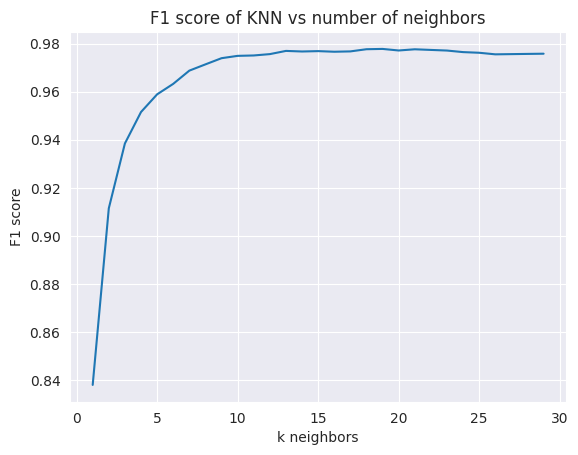

In [171]:
reduction_n_comparaison =[len(table_a_serialized) * len(table_b_serialized) - k * len(table_a_serialized) for k in k_s]

plt.plot(k_s, f1_scores)

plt.title('F1 score of KNN vs number of neighbors')
plt.xlabel('k neighbors')
plt.ylabel('F1 score')
plt.show()